In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely

from pathlib import Path

import programa_azoteas.indices as pindex
import programa_azoteas.data as pdata
import programa_azoteas.scenes as pscenes
import programa_azoteas.shapes as pshapes
import programa_azoteas.angulos as pangles

In [2]:
# Orden de bandas AnalyticMS_SR_clip es Blue, Green, Red, NIR
# Info en nombre de archivo (ej.): 20190109_015005_1020_3B_AnalyticMS.tif is composed of
# 2019-01-09 (acquisition date), 01:50:05 (acquisition time), 1020 (satellite ID), 3B (product level),
# AnalyticMS (product type), and .tif (file extension).

In [3]:
# Direcciones a usar
root_infvit = Path("C:/Users/Mariana/Documents/unam/Proyecto geo friso/Imagenes satelitales planet/Escenas/Infonavit")
root_prepa = Path("C:/Users/Mariana/Documents/unam/Proyecto geo friso/Imagenes satelitales planet/Escenas/ENP8")
root_central = Path("C:/Users/Mariana/Documents/unam/Proyecto geo friso/Imagenes satelitales extra/central_abastos_escenas")

# infonavit trapecio

## Limpieza y obtención de valores (ángulos)

In [4]:
# Shapes a usar del infonavit
shp_barranca = pshapes.get_shape("../Shapes area de estudio/Infonavit/calle_barranca.shp")
shp_infnvt_azotea = pshapes.get_shape("../Shapes area de estudio/Infonavit/infnvt_azotea.shp")

shp_cut1 = pshapes.get_shape("../Shapes area de estudio/Infonavit/Cortes/infnvt_cut1.shp")
shp_cut2 = pshapes.get_shape("../Shapes area de estudio/Infonavit/Cortes/infnvt_cut2.shp")
shp_tree_test = pshapes.get_shape("../Shapes area de estudio/Infonavit/Cortes/infnvt_tree_test.shp")
shp_tree2 = pshapes.get_shape("../Shapes area de estudio/Infonavit/Cortes/infnvt_tree_test2.shp")
shp_rectangle = pshapes.get_shape("../Shapes area de estudio/Infonavit/Cortes/infnvt_rectangle.shp")
shp_white = pshapes.get_shape("../Shapes area de estudio/Infonavit/Cortes/azotea_blanca.shp")
shp_white_small = pshapes.get_shape("../Shapes area de estudio/Infonavit/Cortes/azotea_blanca_chica.shp")
shp_rectangle_small = pshapes.get_shape("../Shapes area de estudio/Infonavit/Cortes/infnvt_rectangle_chico.shp")

In [5]:
infnvt_full = pscenes.load_datasets(root_infvit)

In [6]:
infnvt_scenes = infnvt_full.rio.clip([shp_barranca]) # Clipping a la shape de la calle
infnvt_scenes = infnvt_scenes.fillna(0)
infnvt_scenes = pscenes.remove_nodata(infnvt_scenes) # Quitando aquellas donde no haya imagen (26)

In [7]:
bands = ["cloud_shadow", "light_haze", "heavy_haze", "cloud"]
thresholds_infnvt = [0.01, 0.01, 0.01, 0.01] # Valores aceptables para c/u de las bandas

infnvt_area = pshapes.get_shape_area(infnvt_scenes, shp_infnvt_azotea)

infnvt_clean = infnvt_scenes.copy()
for band_name, threshold in zip(bands, thresholds_infnvt): # Quitando scenes que no cumplan con valores de threshold (aprox 10)
    infnvt_clean = pscenes.clean_scenes(infnvt_clean, infnvt_area, band_name=band_name, threshold=threshold)

In [8]:
# Sacando ángulo cenital promediado por día de las imágenes
xmean = infnvt_clean.x.mean() # Longitud
ymean = infnvt_clean.y.mean() # Latitud

infvnt_zenith_each = []
for date in infnvt_clean.time:
    date = date.item()
    infvnt_zenith_each.append(dict(
        date = pd.to_datetime(date),
        angle = pangles.get_solar_zenith_angle(xmean, ymean, date)
    ))
infvnt_zenith_each = pd.DataFrame(infvnt_zenith_each).set_index("date")["angle"]

In [9]:
# Zenith promediado por mes
infnvt_zenith_monthly = infvnt_zenith_each.resample("M").mean()
infnvt_zenith_monthly.index = infnvt_zenith_monthly.index.strftime('%Y-%m')

C:\Users\Mariana\AppData\Local\Temp\ipykernel_10476\1044009251.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  infnvt_zenith_monthly = infvnt_zenith_each.resample("M").mean()


In [10]:
# Sacando el promedio de la hora en que se sacaron las imágenes por mes
infnvt_time_toma = pdata.df_time_toma(infnvt_clean)
# plt.plot(infnvt_time_toma)
# plt.xticks(rotation=45)

In [11]:
# Sacando los valores de view angle
infnvt_view_angle = pangles.get_df_view_angle(root_infvit)

# Únicamente aquellos de las escenes ya limpiadas
infnvt_view_angle_clean = infnvt_view_angle.loc[infnvt_clean.time.values]

In [12]:
infnvt_view_monthly = infnvt_view_angle_clean.resample("M").mean()
infnvt_view_monthly.index = infnvt_view_monthly.index.strftime('%Y-%m')

C:\Users\Mariana\AppData\Local\Temp\ipykernel_10476\366301639.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  infnvt_view_monthly = infnvt_view_angle_clean.resample("M").mean()


## Actual work con índices

In [13]:
# Sacando índices de vegetación de las imágenes
ndvi_infnvt = pindex.ndvi_scenes(infnvt_clean)
evi_infnvt = pindex.evi_scenes(infnvt_clean, shp_barranca)
srbni_infnvt = pindex.srbni_scenes(infnvt_clean)
savi_infnvt = pindex.savi_scenes(infnvt_clean, shp_barranca)

In [14]:
# t = gpd.GeoSeries(shp_infnvt_azotea.boundary)

# fig, ax = plt.subplots(figsize=(12, 6))
# evi_infnvt[0].plot(ax=ax)
# t.plot(ax=ax, color="r")

In [15]:
# Sacando promedio por mes de las escenas
infnvt_monthly = infnvt_clean.resample(time="M").mean()

c:\Users\Mariana\Documents\unam\Proyecto geo friso\Programa_azoteas\.venv\Lib\site-packages\xarray\groupers.py:392: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [16]:
#Sacando índice de vegetación de las escenas mensuales
infnvt_monthly_ndvi = pindex.ndvi_scenes(infnvt_monthly)
infnvt_monthly_evi = pindex.evi_scenes(infnvt_monthly, shp_barranca)
infnvt_monthly_srbni = pindex.srbni_scenes(infnvt_monthly)
infnvt_monthly_savi = pindex.savi_scenes(infnvt_monthly, shp_barranca)

In [17]:
cuts_infnvt_lst = {
    "cut_izq" : shp_cut1,
    "cut_abajo" : shp_cut2,
    "tree": shp_tree_test,
    "tree_abajo" : shp_tree2,
    "rect_big": shp_rectangle,
    "white_roof" : shp_white,
    "white_roof_small" : shp_white_small,
    "rect_small" : shp_rectangle_small
}

In [18]:
df_infnvt_indices = []
for key, value in cuts_infnvt_lst.items():
    for df, name in zip([infnvt_monthly_evi, infnvt_monthly_ndvi, infnvt_monthly_srbni, infnvt_monthly_savi], ["evi", "ndvi", "srbni", "savi"]):
        temp_df = pdata.get_df_monthly(df, value)
        temp_df["name"] = name
        temp_df["cut"] = key
        df_infnvt_indices.append(temp_df)

df_infnvt_indices = (
    pd.concat(df_infnvt_indices)
    .reset_index()
    .rename(columns={"index": "date"})
    .set_index(["cut", "name", "date"])
    .sort_index()
)

In [19]:
# fig, ax = plt.subplots(figsize=(12, 6))
# pindex.plot_index_comparison(df_infnvt_indices, "cut_izq", ax=ax)
# plt.plot(infnvt_zenith_monthly/100)

In [20]:
# fig, ax = plt.subplots(figsize=(12, 6))
# pindex.plot_index_comparison(df_infnvt_indices, "rect_small", ax=ax)

In [21]:
# fig, ax = plt.subplots(figsize=(12, 6))
# pindex.plot_index_comparison(df_infnvt_indices, "tree", ax=ax)

In [22]:
# plt.plot(df_infnvt_indices.xs("evi", level="name").xs("rect_small", level="cut")["value"]) # 0.1, blue
# plt.plot(df_infnvt_indices.xs("evi", level="name").xs("tree", level="cut")["value"]) # 0.4, orange
# # plt.plot(df_infnvt_indices.xs("evi", level="name").xs("cut_izq", level="cut")["value"]) # 0.2, green
# # plt.plot(infnvt_zenith_monthly/100) # red
# plt.plot(infnvt_view_monthly/10)

# Infonavit trapecio hueco

In [23]:
shp_infnvt_hole = pshapes.get_shape("../Shapes area de estudio/Infonavit/infnvt_hollow.shp")

In [24]:
inf_sc_hole = infnvt_clean.rio.clip([shp_infnvt_hole])

In [25]:
inf_hole_monthly = inf_sc_hole.resample(time="M").mean()

c:\Users\Mariana\Documents\unam\Proyecto geo friso\Programa_azoteas\.venv\Lib\site-packages\xarray\groupers.py:392: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [26]:
hole_monthly_ndvi = pindex.ndvi_scenes(inf_hole_monthly)
hole_monthly_evi = pindex.evi_scenes(inf_hole_monthly, shp_infnvt_hole)
hole_monthly_savi = pindex.savi_scenes(inf_hole_monthly, shp_infnvt_hole)

In [27]:
# df_hole_ndvi = pdata.get_df_monthly(hole_monthly_ndvi, shp_infnvt_hole)
# df_hole_evi = pdata.get_df_monthly(hole_monthly_evi, shp_infnvt_hole)
# df_hole_savi = pdata.get_df_monthly(hole_monthly_savi, shp_infnvt_hole)

In [28]:
cut_hole_lst ={
    "hollow" : shp_infnvt_hole
}

In [29]:
df_hole_indices = []
for key, value in cut_hole_lst.items():
    for df, name in zip([hole_monthly_ndvi, hole_monthly_evi, hole_monthly_savi], ["ndvi", "evi", "savi"]):
        temp_df = pdata.get_df_monthly(df, value)
        temp_df["name"] = name
        temp_df["cut"] = key
        df_hole_indices.append(temp_df)

df_hole_indices = (
    pd.concat(df_hole_indices)
    .reset_index()
    .rename(columns={"index": "date"})
    .set_index(["cut", "name", "date"])
    .sort_index()
)

In [92]:
# fig, ax = plt.subplots(figsize=(12, 6))
# pindex.plot_index_comparison(df_hole_indices, "hollow", ax=ax)

In [ ]:
# df_hole_indices.to_csv("../csv final/planet_vi_infnvt_hollow.csv")

# Anexo

In [31]:
shp_anexo_calle = pshapes.get_shape("../Shapes area de estudio/Anexo/anexo_calle.shp")

shp_anexo = []
for i in range(1, 5):
    shp_temp = pshapes.get_shape(f"../Shapes area de estudio/Anexo/anexo{i}.shp")
    shp_anexo.append(shp_temp)

shp_anexo = shapely.union_all(shp_anexo)

In [32]:
anexo_scenes = infnvt_full.rio.clip([shp_anexo])
anexo_scenes = anexo_scenes.fillna(0)
anexo_scenes = pscenes.remove_nodata(anexo_scenes)

In [33]:
bands_clean = ["cloud_shadow", "light_haze", "heavy_haze", "cloud"]
thresholds_anexo = [0.01, 0.01, 0.01, 0.01] # Valores aceptables para c/u de las bandas

anexo_area = pshapes.get_shape_area(anexo_scenes, shp_anexo)

anexo_clean = anexo_scenes.copy()
for band_name, threshold in zip(bands_clean, thresholds_anexo): # Quitando scenes que no cumplan con valores de threshold (aprox 10)
    anexo_clean = pscenes.clean_scenes(anexo_clean, anexo_area, band_name=band_name, threshold=threshold)

In [34]:
anexo_monthly = anexo_clean.resample(time="M").mean()

c:\Users\Mariana\Documents\unam\Proyecto geo friso\Programa_azoteas\.venv\Lib\site-packages\xarray\groupers.py:392: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [35]:
anexo_monthly_ndvi = pindex.ndvi_scenes(anexo_monthly)

In [36]:
anexo_monthly_ndvi = pindex.ndvi_scenes(anexo_monthly)
anexo_monthly_evi = pindex.evi_scenes(anexo_monthly, shp_anexo)
anexo_monthly_savi = pindex.savi_scenes(anexo_monthly, shp_anexo)

In [37]:
cut_anexo_lst = {
    "anexo" : shp_anexo
}

In [38]:
df_anexo_indices = []
for key, value in cut_anexo_lst.items():
    for df, name in zip([anexo_monthly_ndvi, anexo_monthly_evi, anexo_monthly_savi], ["ndvi", "evi", "savi"]):
        temp_df = pdata.get_df_monthly(df, value)
        temp_df["name"] = name
        temp_df["cut"] = key
        df_anexo_indices.append(temp_df)

df_anexo_indices = (
    pd.concat(df_anexo_indices)
    .reset_index()
    .rename(columns={"index": "date"})
    .set_index(["cut", "name", "date"])
    .sort_index()
)

In [76]:
# fig, ax = plt.subplots(figsize=(12, 6))
# pindex.plot_index_comparison(df_anexo_indices, "anexo", ax=ax)

In [40]:
# plt.plot(df_anexo_indices.xs("ndvi", level="name").xs("anexo", level="cut")["value"])
# plt.plot(df_hole_indices.xs("ndvi", level="name").xs("hollow", level="cut")["value"])

In [77]:
anex_ndvi = df_anexo_indices.xs("ndvi", level="name").xs("anexo", level="cut")["value"]
anex_evi = df_anexo_indices.xs("evi", level="name").xs("anexo", level="cut")["value"]
anex_savi = df_anexo_indices.xs("savi", level="name").xs("anexo", level="cut")["value"]

hole_ndvi = df_hole_indices.xs("ndvi", level="name").xs("hollow", level="cut")["value"]
hole_evi = df_hole_indices.xs("evi", level="name").xs("hollow", level="cut")["value"]
hole_savi = df_hole_indices.xs("savi", level="name").xs("hollow", level="cut")["value"]

In [88]:
rec_evi = df_infnvt_indices.xs("evi", level="name").xs("rect_small", level="cut")["value"]

In [42]:
# df = pd.concat([anex_ndvi, hole_ndvi], axis=1, keys=["anexo", "infnvt"]).reset_index().melt(id_vars=["date"])
# fig, ax = plt.subplots(figsize=(16, 6))
# sns.lineplot(df, hue="variable", x="date", y="value")

Text(0.5, 1.0, 'evi')

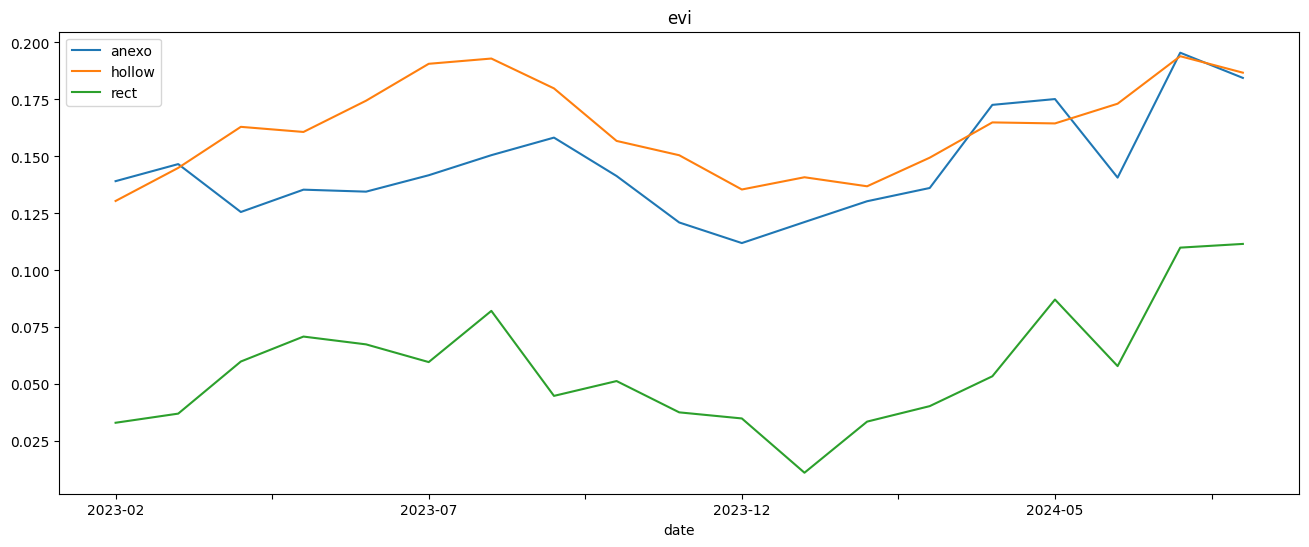

In [89]:
fig, ax = plt.subplots(figsize=(16, 6))
anex_evi.plot(ax=ax, label="anexo")
hole_evi.plot(ax=ax, label="hollow")
rec_evi.plot(ax=ax, label="rect")
ax.legend()
ax.set_title("evi")

# Central de abastos

In [44]:
shp_central = pshapes.get_shape("../Shapes area de estudio/Extra/central_abastos.shp")

In [45]:
central_full, central_cloud, central_cloudprob, central_cloudscore = pscenes.load_datasets_sentinel(root_central)

In [46]:
central_cloud_mask = pscenes.get_clean_cloudscore_mask(central_cloudscore, 0.9)

In [47]:
central_clean = central_full[central_cloud_mask]

In [48]:
ndvi_central = pindex.ndvi_scenes(central_clean)
evi_central = pindex.evi_scenes(central_clean, shp_central)
savi_central = pindex.savi_scenes(central_clean, shp_central)

In [49]:
central_monthly = central_clean.resample(time="M").mean()

c:\Users\Mariana\Documents\unam\Proyecto geo friso\Programa_azoteas\.venv\Lib\site-packages\xarray\groupers.py:392: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [50]:
central_monthly_ndvi = pindex.ndvi_scenes(central_monthly)
central_monthly_evi = pindex.evi_scenes(central_monthly, shp_central)
central_monthly_savi = pindex.savi_scenes(central_monthly, shp_central)

central_monthly_evi = central_monthly_evi.where(central_monthly_evi != -np.inf, np.nan)

In [51]:
cuts_central_lst = {
    "central" : shp_central
}

In [52]:
df_central_indices = []
for key, value in cuts_central_lst.items():
    for df, name in zip([central_monthly_ndvi, central_monthly_evi, central_monthly_savi], ["ndvi", "evi", "savi"]):
        temp_df = pdata.get_df_monthly(df, shp_central)
        temp_df["name"] = name
        temp_df["cut"] = key
        df_central_indices.append(temp_df)

df_central_indices = (
    pd.concat(df_central_indices)
    .reset_index()
    .rename(columns={"index": "date"})
    .set_index(["cut", "name", "date"])
    .sort_index()
)

In [91]:
# fig, ax = plt.subplots(figsize=(12, 6))
# pindex.plot_index_comparison(df_central_indices, "central", ax=ax)

In [54]:
# plt.plot(df_infnvt_indices.xs("savi", level="name").xs("rect_small", level="cut")["value"])
# # plt.plot(df_central_indices[0]["value"]) # ndvi
# # plt.plot(df_central_indices[1]["value"]) # evi
# plt.plot(df_central_indices[2]["value"]) # savi

# Prepa

In [55]:
# Shapes a usar de la prepa
shp_prepa_calle = pshapes.get_shape("../Shapes area de estudio/ENP8/enp8_calle.shp")
shp_prepa_azotea = pshapes.get_shape("../Shapes area de estudio/ENP8/enp8_azotea.shp")

shp_prepa_tree = pshapes.get_shape("../Shapes area de estudio/ENP8/Cortes/enp8_tree.shp")

In [56]:
prepa_full = pscenes.load_datasets(root_prepa)

In [57]:
prepa_scenes = prepa_full.rio.clip([shp_prepa_calle]) # Clipping a la shape de la calle
prepa_scenes = prepa_scenes.fillna(0)
prepa_scenes = pscenes.remove_nodata(prepa_scenes) # Quitando aquellas donde no haya imagen (6)

In [58]:
# Usando bands previously stablished
thresholds_prepa = [0.01, 0.01, 0.01, 0.01]

prepa_area = pshapes.get_shape_area(prepa_scenes, shp_prepa_azotea )

prepa_clean = prepa_scenes.copy()
for band_name, threshold in zip(bands, thresholds_prepa): # Quitando scenes que no cumplan con valores de threshold (9)
    prepa_clean = pscenes.clean_scenes(prepa_clean, prepa_area, band_name=band_name, threshold=threshold)

In [59]:
# ndvi de las imágenes
ndvi_prepa = pindex.ndvi_scenes(prepa_clean)

In [60]:
# fig, ax = plt.subplots(figsize=(12, 6))
# ndvi_prepa[0].plot(ax=ax)

In [61]:
prepa_monthly = prepa_clean.resample(time="M").mean()

c:\Users\Mariana\Documents\unam\Proyecto geo friso\Programa_azoteas\.venv\Lib\site-packages\xarray\groupers.py:392: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [62]:
prepa_monthly_ndvi = pindex.ndvi_scenes(prepa_monthly)
prepa_monthly_evi = pindex.evi_scenes(prepa_monthly, shp_prepa_calle)
prepa_monthly_srbni = pindex.srbni_scenes(prepa_monthly)
prepa_monthly_savi = pindex.savi_scenes(prepa_monthly, shp_prepa_calle)

In [63]:
cuts_prepa_lst = {
    "azotea" : shp_prepa_azotea,
    "tree" : shp_prepa_tree
}

In [64]:
df_prepa_indices = []
for key, value in cuts_prepa_lst.items():
    for df, name in zip([prepa_monthly_evi, prepa_monthly_ndvi, prepa_monthly_srbni, prepa_monthly_savi], ["evi", "ndvi", "srbni", "savi"]):
        temp_df = pdata.get_df_monthly(df, value)
        temp_df["name"] = name
        temp_df["cut"] = key
        df_prepa_indices.append(temp_df)

df_prepa_indices = (
    pd.concat(df_prepa_indices)
    .reset_index()
    .rename(columns={"index": "date"})
    .set_index(["cut", "name", "date"])
    .sort_index()
)

In [65]:
# fig, ax = plt.subplots(figsize=(12, 6))
# ndvi_prepa[0].plot(ax=ax)

In [66]:
# plt.plot(df_prepa_indices.xs("tree", level="cut").xs("ndvi", level="name")["value"])
# plt.plot(df_prepa_indices.xs("azotea", level="cut").xs("ndvi", level="name")["value"])

# Alineación de imágenes a mano (infonavit trapecio) (se cancela)

In [67]:
# Creando geodataframe con geometries de los puntos del shape de infoanvit para alineo
# infnvt_points: gpd.GeoDataFrame = gpd.read_file("../Puntos shift alineacion/Infonavit/infnvt_base.shp")
# infnvt_points["index"] = infnvt_points["Datetime"].str[-1].astype(int) # Obteniendo si es punto de la izquierda (1) o derecha (2)
# infnvt_points["Datetime"] = infnvt_points["Datetime"].apply(get_time_from_name)

# infnvt_points["lon"] = infnvt_points["geometry"].x
# infnvt_points["lat"] = infnvt_points["geometry"].y

# infnvt_points = infnvt_points.drop(columns=["Visible", "geometry"]).set_index(["Datetime", "index"]).sort_index() # Multiindex por datetime y tipo de index

In [68]:
# infnvt_p1 = infnvt_points.loc[pd.IndexSlice[:, 1], :].reset_index(level=1, drop=True) # Creando df con puntos 1 (izquierda)
# infnvt_p2 = infnvt_points.loc[pd.IndexSlice[:, 2], :].reset_index(level=1, drop=True) #  Creando df con puntos 2 (derecha)

In [69]:
# inft_delta1 = (infnvt_p1 - infnvt_p1.iloc[0]).astype("int64") # Sacando diferencia con punto base [0]
# inft_delta2 = (infnvt_p2 - infnvt_p2.iloc[0]).astype("int64") # # Sacando diferencia con punto base [0]
# inft_delta = ((((inft_delta1 + inft_delta2) / 2) / 3).round()).astype("int64") # Promedio de diferencias entre ambos puntos por escena, se divide entre 3
#                                                             # porquec/pixel es de 3x3, y queremos saber cuántos pixeles se debe mover
# inft_delta["lat"] = inft_delta["lat"] * -1 # Porque al hacer la función shift un valor positivo de y mueve hacia abajo el array, y viceversa

In [70]:
# shift_test = infnvt_clean.sel(time=inft_delta.index) # Sacando los arrays de los dates de los que se hicieron puntos

In [71]:
# new_shift = []
# for i in range(0, len(inft_delta.index)):
#     new_shift.append(shift_test[i].shift(x=inft_delta["lon"].iloc[i], y=inft_delta["lat"].iloc[i]))

In [72]:
# arr = new_shift[2].copy()
# arr.attrs["long_name"] = ("blue", "green", "red", "nir", 'clear', 'snow', 'cloud_shadow', 'light_haze', 'heavy_haze', 'cloud', 'confidence', 'unusable')

In [73]:
# arr.rio.to_raster("xd.tif")